### Load the cellsnplite calls for RNA and ATAC

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

### Load in the RNA cellsnplite results

In [2]:
raw_data_dir = "raw_data_Dropseq/"
RNA_directories = os.listdir(raw_data_dir) 
RNA_directories = [f for f in RNA_directories if f.startswith("Fetal-") ]
RNA_snp_call_files = [raw_data_dir + f + "/STAR/cellsnplite/cellSNP.base.vcf.gz" for f in RNA_directories]

In [3]:
RNA_snp_df_list = list()

for snp_file in RNA_snp_call_files:
    print(snp_file)
    df =  pd.read_csv(snp_file, compression = "gzip", delim_whitespace=True, header=1).reset_index(drop = True)
    RNA_snp_df_list.append(df)

../raw_data_Dropseq/Fetal-2nd-Atria-2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LV-18wk-e3/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LRV-18wk-male1-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-1st-LV-0315-1-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-2nd-Atria-1/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-2nd-OFT-2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-1st-LV-0315-2-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LRV-18wk-male3-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-2nd-OFT-1/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LV-18wk-e2-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LRV-18wk-male2-run1n2/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-Atria-18wk/STAR/cellsnplite/cellSNP.base.vcf.gz
../raw_data_Dropseq/Fetal-LRV-18wk-male4-run1n2/STAR

In [4]:
# combine the RNA and ATAC together
overall_snp_df_list = RNA_snp_df_list 

RNA_sample_names = ["RNA:" + f for f in RNA_directories]

# combine the names together
combined_sample_names = RNA_sample_names 

In [5]:
# initialize an empty similarity matrix
n = len(overall_snp_df_list)
similarity_matrix = pd.DataFrame(0.0, index=range(n), columns=range(n))

# Calculate percentage overlap between each pair of dataframes
for i in range(n):
    for j in range(i, n):
        # Get SNP positions for each dataframe
        snps_i = set(overall_snp_df_list[i][['#CHROM', 'POS', 'REF', 'ALT']].itertuples(index=False, name=None))
        snps_j = set(overall_snp_df_list[j][['#CHROM', 'POS', 'REF', 'ALT']].itertuples(index=False, name=None))
        
        # Calculate overlap
        intersection = len(snps_i & snps_j)
        #union = len(snps_i | snps_j)
        #overlap_percentage = (intersection / union) * 100 if union > 0 else 0

        min_set_size = min(len(snps_i), len(snps_j))
        overlap_percentage = np.round((intersection / min_set_size), 2) * 100 if min_set_size > 0 else 0

        # Fill in the similarity matrix (symmetric matrix)
        similarity_matrix.iat[i, j] = overlap_percentage
        similarity_matrix.iat[j, i] = overlap_percentage

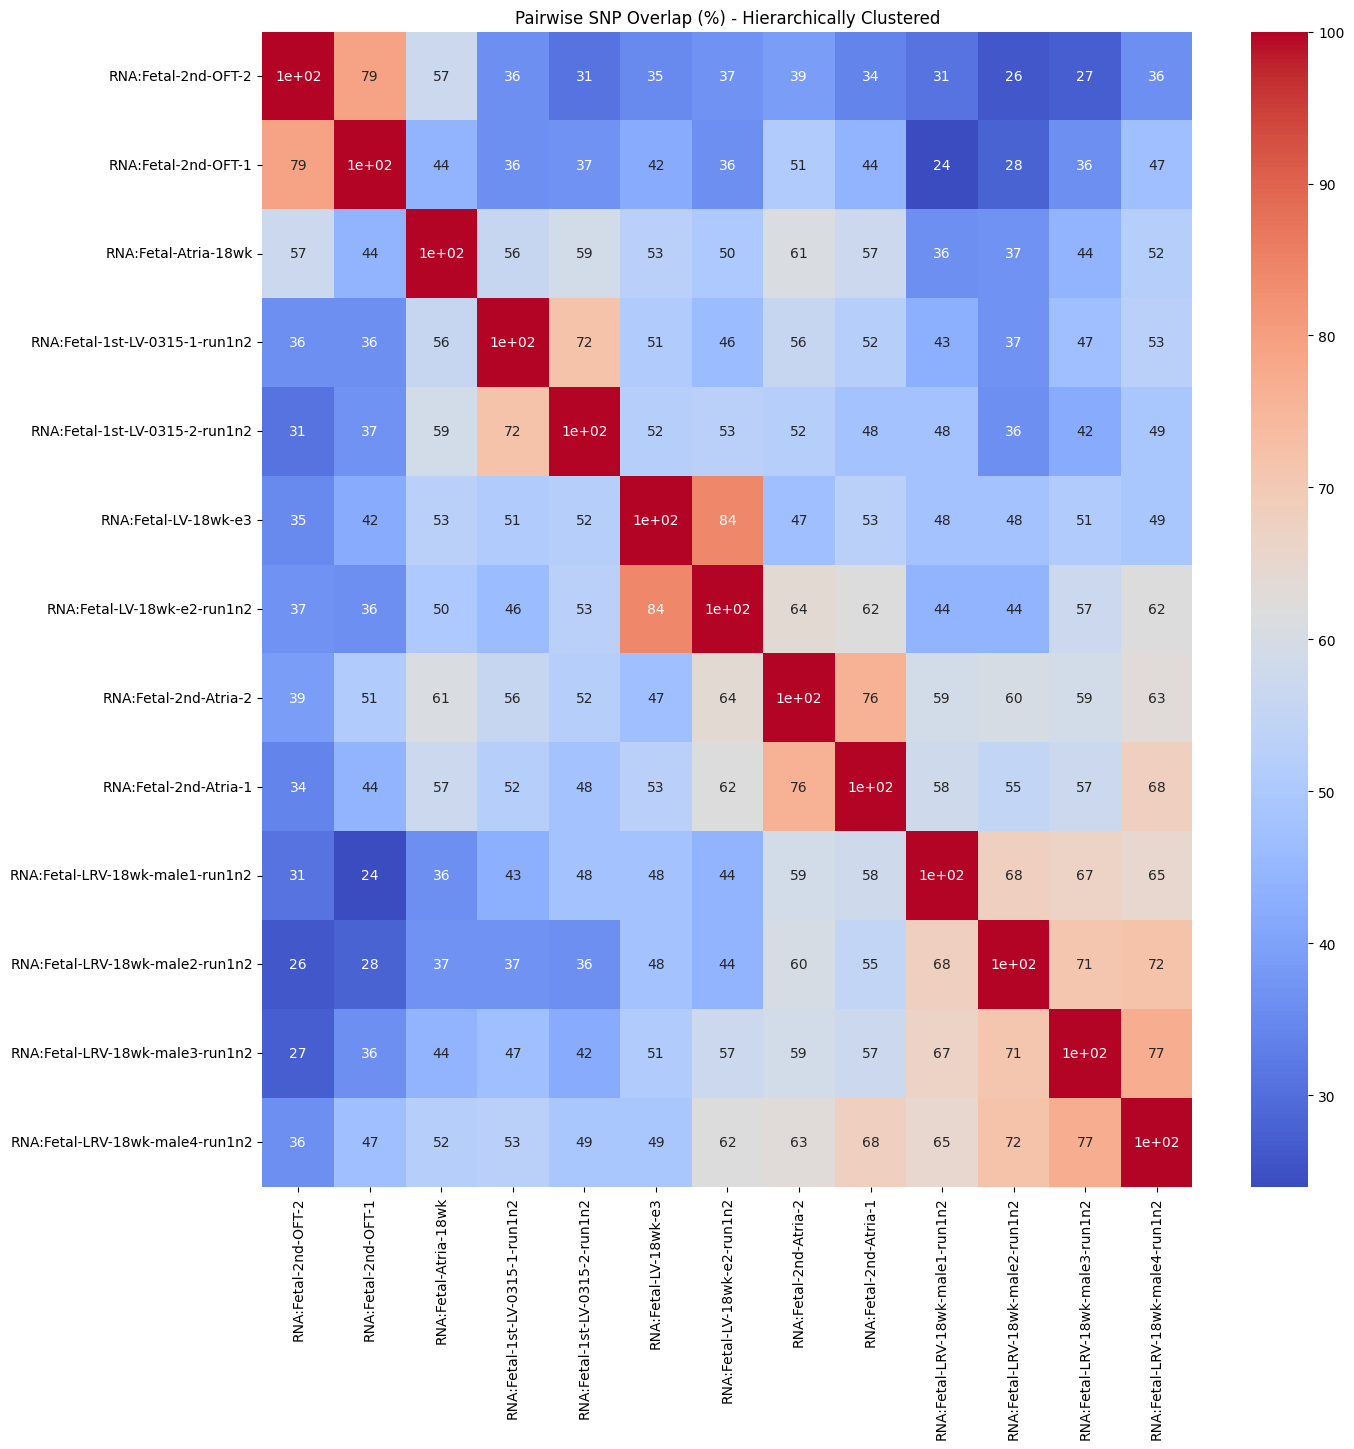

In [6]:
# Hierarchical clustering
distance_matrix = 1 - (similarity_matrix / 100)
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Get ordered indices based on hierarchical clustering
ordered_indices = leaves_list(linkage_matrix)

# Reorder similarity matrix and RNA directories based on clustering
ordered_similarity_matrix = similarity_matrix.iloc[ordered_indices, ordered_indices]
ordered_labels = np.array(combined_sample_names)[ordered_indices]

# Plot the heatmap with hierarchical order
plt.figure(figsize=(15, 15))
sns.heatmap(ordered_similarity_matrix, annot=True, cmap='coolwarm',
            xticklabels=ordered_labels, yticklabels=ordered_labels)
plt.title('Pairwise SNP Overlap (%) - Hierarchically Clustered')
plt.xticks(rotation=90)
plt.show()

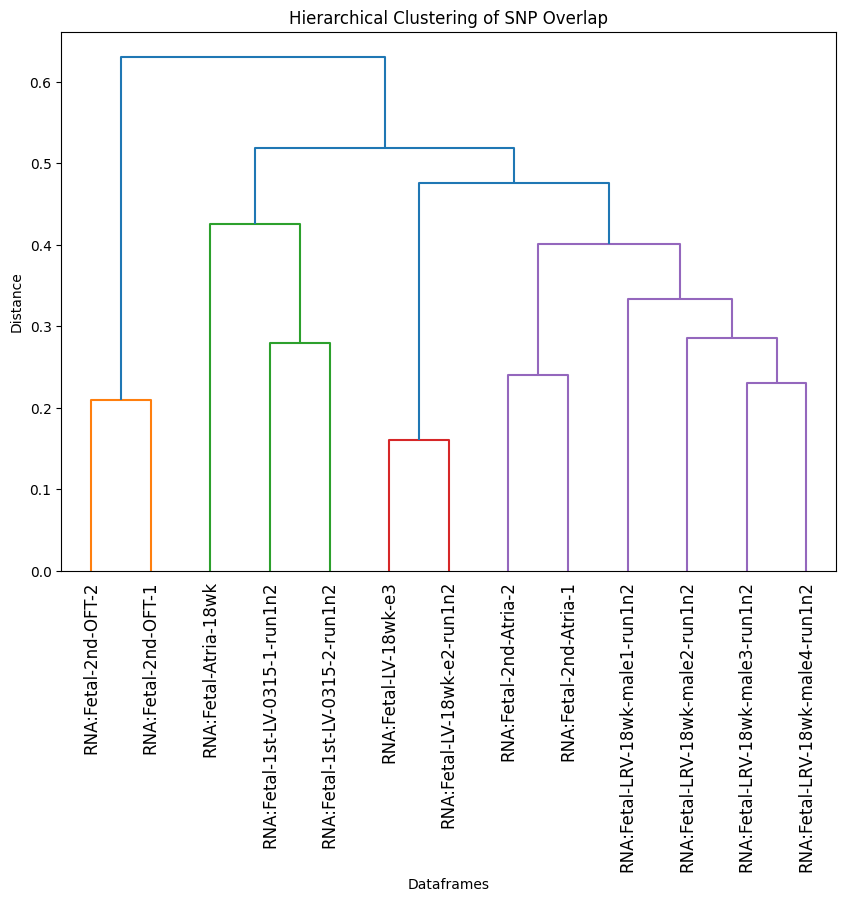

In [7]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=combined_sample_names, leaf_rotation=90)
plt.title('Hierarchical Clustering of SNP Overlap')
plt.xlabel('Dataframes')
plt.ylabel('Distance')
plt.show()